# Zurich Instruments Lock-In MFLI Data Aquesition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import time

In [4]:
import matplotlib.pyplot as plt

In [5]:
from zhinst import ziPython as zhinst_core

In [6]:
import qupulse

In [7]:
from qupulse.hardware.dacs.mfli import MFLIDAQ

z:\git\qupulse\qupulse\hardware\awgs\tektronix.py:13: UserWarning: Could not import Tektronix driver backend. If you wish to use it execute qupulse.hardware.awgs.install_requirements('tektronix')
  warnings.warn("Could not import Tektronix driver backend. "


In [8]:
my_lockin = MFLIDAQ(device_serial="dev3442", device_interface="PCIe", data_server_addr="192.168.53.202")

In [9]:
my_lockin.assumed_minimal_sample_rate = 1.

In [10]:
my_lockin_channels = {
    "R": ["demods/0/sample.R"],
    "X": ["demods/0/sample.X"],
    "Y": ["demods/0/sample.Y"],
    "A": ["auxins/0/sample.AuxIn0.avg"],
    "many": ["demods/0/sample.R", "auxins/0/sample.AuxIn0.avg", "demods/0/sample.X", "demods/0/sample.Y"]
}

In [11]:
for k, v in my_lockin_channels.items():
    my_lockin.register_measurement_channel(program_name=None, channel_path=v, window_name=k)

In [12]:
my_lockin.programs[None]

{'channel_mapping': {'R': {'demods/0/sample.R'},
  'X': {'demods/0/sample.X'},
  'Y': {'demods/0/sample.Y'},
  'A': {'auxins/0/sample.AuxIn0.avg'},
  'many': {'auxins/0/sample.AuxIn0.avg',
   'demods/0/sample.R',
   'demods/0/sample.X',
   'demods/0/sample.Y'}}}

In [13]:
my_lockin.register_measurement_windows(program_name="test", windows={"A": (np.array([0, 3])*1, np.array([1, 10])*1), "many": (np.array([0, 2, 4])*1e-3, np.array([1, 4, 6.1])*1e-3)})

1674.107177734375
1674.107177734375
1674.107177734375


In [14]:
my_lockin.programs

{None: {'channel_mapping': {'R': {'demods/0/sample.R'},
   'X': {'demods/0/sample.X'},
   'Y': {'demods/0/sample.Y'},
   'A': {'auxins/0/sample.AuxIn0.avg'},
   'many': {'auxins/0/sample.AuxIn0.avg',
    'demods/0/sample.R',
    'demods/0/sample.X',
    'demods/0/sample.Y'}}},
 'test': {'windows': {'A': (array([0, 3]), array([ 1, 10])),
   'many': (array([0.   , 0.002, 0.004]), array([0.001 , 0.004 , 0.0061]))},
  'masks': {'A': {'mask': array([[[0.],
            [0.]],
    
           [[0.],
            [0.]],
    
           [[0.],
            [0.]]]),
    'channels': {'auxins/0/sample.AuxIn0.avg'},
    'sample_rates': [None]},
   'many': {'mask': array([[[0., 0., 0., 0.],
            [0., 0., 0., 0.],
            [0., 0., 0., 0.]],
    
           [[0., 0., 0., 0.],
            [0., 0., 0., 0.],
            [0., 0., 0., 0.]],
    
           [[0., 0., 0., 0.],
            [0., 0., 0., 0.],
            [0., 0., 0., 0.]]]),
    'channels': {'auxins/0/sample.AuxIn0.avg',
     'demods/0

In [15]:
my_lockin.delete_program(program_name="test")

In [16]:
my_lockin.programs

{None: {'channel_mapping': {'R': {'demods/0/sample.R'},
   'X': {'demods/0/sample.X'},
   'Y': {'demods/0/sample.Y'},
   'A': {'auxins/0/sample.AuxIn0.avg'},
   'many': {'auxins/0/sample.AuxIn0.avg',
    'demods/0/sample.R',
    'demods/0/sample.X',
    'demods/0/sample.Y'}}}}

## Defining a simple qupulse pulse with a measurement window.

In [17]:
from qupulse.pulses.plotting import plot

In [18]:
red_pulse = qupulse.pulses.TablePT({"red": [
    ("0*dt", 0),
    ("1*dt", 4, 'hold'),
    ("4*dt", .5, 'linear'),
    ("5*dt", 2, 'hold'),
    ("6*dt", .5, 'hold'),
    ("15*dt", .5, 'jump'),
]})

In [40]:
green_pulse = qupulse.pulses.SequencePT(*[
    qupulse.pulses.FunctionPT(".1", "6*dt", channel="green"),
    qupulse.pulses.FunctionPT(".1+(t/dt)**2*.9", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("1", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("1+sin((t/dt)*2*pi)*exp(-((t/dt)-2)**2)", "5*dt", channel="green"),
    qupulse.pulses.FunctionPT("1", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("0", "1*dt", channel="green"),
]
)

In [41]:
measured_pt = qupulse.pulses.PointPT([("0*dt", 0), ("0*dt", 1), ("15*dt", 1), ("15*dt", 0)],
                      channel_names=("trigger_out",),
                      measurements=[('A', "dt*3", "dt*1.5"), ('A', "dt*12", "dt*3"), ('R', "dt*6.5", "dt*1.4"), ('R', "dt*14", "dt*1"), ('T', "dt*10", "dt*3")])

In [42]:
combined_pulse = red_pulse+green_pulse+measured_pt

z:\git\qupulse\qupulse\pulses\arithmetic_pulse_template.py:72: ImplicitAtomicityInArithmeticPT: ArithmeticAtomicPulseTemplate treats all operands as if they are atomic. You can silence this warning by passing `silent_atomic=True` or by ignoring this category.
  category=ImplicitAtomicityInArithmeticPT)


In [43]:
print(combined_pulse.measurement_names)
print(combined_pulse.measurement_declarations)
print(combined_pulse.measurement_parameters)

{'A', 'T', 'R'}
[]
set()


In [44]:
combined_pulse.get_measurement_windows

<bound method ArithmeticAtomicPulseTemplate.get_measurement_windows of ((TablePulseTemplate(entries={'red': [(0, 0, 'hold'), ('1*dt', 4, 'hold'), ('4*dt', 0.5, 'linear'), ('5*dt', 2, 'hold'), ('6*dt', 0.5, 'hold'), ('15*dt', 0.5, 'jump')]},parameter_constraints=[],measurements=[]) '+' SequencePulseTemplate(subtemplates=[FunctionPulseTemplate(duration_expression=ExpressionScalar('6*dt'),expression=ExpressionScalar('.1'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('1*dt'),expression=ExpressionScalar('.1+(t/dt)**2*.9'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('1*dt'),expression=ExpressionScalar('1'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('5*dt'),expression=ExpressionScalar('1+sin((t/dt)*2*pi)*exp(-((t/dt)-2)**2)'),channel='green',measurements=[],parameter_constra

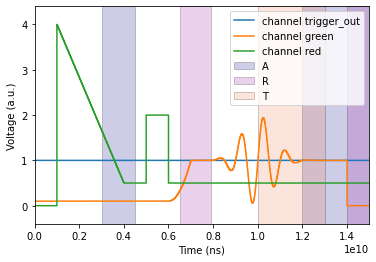

In [48]:
plot(combined_pulse, sample_rate=1e-7, plot_measurements=combined_pulse.measurement_names, parameters={"dt": 1e9}) # combined_pulse.measurement_names
plt.show()

In [49]:
idle_pulse = qupulse.pulses.TablePT({"red": [
    ("0*dt", 0),
    ("5*dt", 0),
],
                                     "green": [
    ("0*dt", 0),
    ("5*dt", 0),
],
                                     "trigger_out": [
    ("0*dt", 0),
    ("5*dt", 0),
]})

In [50]:
rep = qupulse.pulses.repetition_pulse_template.RepetitionPulseTemplate(
    body=qupulse.pulses.SequencePT(combined_pulse, idle_pulse),
    repetition_count=10
)

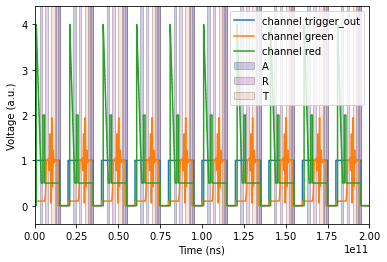

In [51]:
plot(rep, sample_rate=1e-7, plot_measurements=combined_pulse.measurement_names, parameters={"dt": 1e9})
plt.show()

## Execution

1. map output channels to dummy instrument
2. arm scan and see if everything works

In [67]:
from qupulse.utils.types import TimeType

In [52]:
from qupulse.hardware.awgs.virtual import VirtualAWG

In [53]:
from qupulse.hardware.setup import HardwareSetup, MeasurementMask, PlaybackChannel

In [54]:
my_awg = VirtualAWG("awg", channels=3)

In [55]:
setup = HardwareSetup()

In [56]:
for n in my_lockin.programs[None]["channel_mapping"].keys():
    setup.set_measurement(f"{n}", MeasurementMask(my_lockin, n))

In [57]:
for i, c in enumerate(["red", "green", "trigger_out"]):
    setup.set_channel(f"{c}", PlaybackChannel(my_awg, i))

In [60]:
test_program = combined_pulse.create_program(measurement_mapping={"A":"A", "R":"R", "T":"X"},parameters={"dt": 1e9})

In [83]:
setup.register_program('test', test_program, run_callback=lambda *a, **b: my_lockin.force_trigger(None), update=True)

In [78]:
15e-9*1674.107177734375

2.5111607666015624e-05

In [84]:
my_lockin.programs

{None: {'channel_mapping': {'R': {'demods/0/sample.R'},
   'X': {'demods/0/sample.X'},
   'Y': {'demods/0/sample.Y'},
   'A': {'auxins/0/sample.AuxIn0.avg'},
   'many': {'auxins/0/sample.AuxIn0.avg',
    'demods/0/sample.R',
    'demods/0/sample.X',
    'demods/0/sample.Y'}}},
 'test': {'windows': {'X': (array([1.e+10]), array([3.e+09])),
   'R': (array([6.5e+09, 1.4e+10]), array([1.4e+09, 1.0e+09])),
   'A': (array([3.0e+09, 1.2e+10]), array([1.5e+09, 3.0e+09]))},
  'masks': {'X': {'mask': array([[[16741.]],
    
           [[ 5022.]],
    
           [[21763.]]]),
    'channels': {'demods/0/sample.X'},
    'sample_rates': [TimeType(6857143, 4096)]},
   'R': {'mask': array([[[10882.],
            [23438.]],
    
           [[ 2343.],
            [ 1674.]],
    
           [[13225.],
            [25112.]]]),
    'channels': {'demods/0/sample.R'},
    'sample_rates': [TimeType(6857143, 4096)]},
   'A': {'mask': array([[[ 3.],
            [12.]],
    
           [[ 1.],
            [ 3.]

In [85]:
setup.run_program("test")

z:\git\qupulse\qupulse\hardware\dacs\mfli.py:301: UserWarning: The channel auxins/0/sample.AuxIn0.avg does not have an interface for enabling it. If needed, this can be done using the web interface.
  # select the value to measure


In [86]:
data = my_lockin.measure_program([""])

waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
waiting for device dev3442 to finish the acquisition.
{'buffercount': array([77], dtype=int64), 'dev3442': {'auxins': {'0': {'sample.auxin0.avg': [{'header': {'systemtime': array([1664448415

z:\git\qupulse\qupulse\hardware\dacs\mfli.py:473: UserWarning: For at least one received channel entries with different dimensions are present. This might lead to undesired masking! (The code will not raise an exception.) ({'/dev3442/auxins/0/sample.auxin0.avg': {(1, 25112)}, '/dev3442/demods/0/sample.r': {(1, 25112)}, '/dev3442/demods/0/sample.x': {(1, 25112)}})
  return recorded_data


In [87]:
data

{'/dev3442/auxins/0/sample.auxin0.avg': [<xarray.DataArray '/dev3442/auxins/0/sample.auxin0.avg' (col: 1, row: 25112)>
  array([[        nan,         nan,         nan, ..., -0.00159835,
          -0.00163236, -0.00166638]])
  Coordinates:
      timestamp  (col, row) uint64 0 0 0 ... 614064834713 614064870553
  Dimensions without coordinates: col, row
  Attributes:
      systemtime:        [1664448415930365]
      createdtimestamp:  [613164903993]
      changedtimestamp:  [613164903993]
      flags:             [825]
      moduleflags:       [0]
      chunksizebytes:    [0]
      name:              002 12:46:55.9296
      status:            [0]
      groupindex:        [0]
      color:             [0]
      activerow:         [0]
      triggernumber:     [0]
      gridrows:          [1]
      gridcols:          [25112]
      gridmode:          [4]
      gridoperation:     [1]
      griddirection:     [0]
      gridrepetitions:   [1]
      gridcoldelta:      [0.00059733]
      gridcoloff

In [100]:
for e in data['/dev3442/auxins/0/sample.auxin0.avg'][0].values[0, :40]:
    print(e)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.0003317117807455361
-0.0003317117807455361


In [103]:
my_lockin._parse_data(data, program_name="test")

/dev3442/demods/0/sample.x
(1, 25112)
[[16741. 16742. 16743. ... 21761. 21762. 21763.]]
(1, 5023)
/dev3442/demods/0/sample.r
(1, 25112)
[[10882. 10883. 10884. ... 13223. 13224. 13225.]
 [23438. 23439. 23440. ...    nan    nan    nan]]
(2, 2344)
/dev3442/auxins/0/sample.auxin0.avg
(1, 25112)
[[ 3.  4. nan nan]
 [12. 13. 14. 15.]]
(2, 4)


In [59]:
%debug

> c:\users\surrey\miniconda3\envs\py37\lib\site-packages\numpy\core\numeric.py(342)full()
    340         fill_value = asarray(fill_value)
    341         dtype = fill_value.dtype
--> 342     a = empty(shape, dtype, order)
    343     multiarray.copyto(a, fill_value, casting='unsafe')
    344     return a

ipdb> shape
(2, -2147483647)
ipdb> u
> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(390)_parse_data()
    388 
    389                                 # building the mask to apply to the data now:
--> 390                                 applicable_mask = np.full((_mask.shape[1], np.nanmax(_mask[1, :, ci]).astype(int)+1), np.nan)
    391                                 # the following code could probably be optimized with some numpy magic
    392                                 for wi, w in enumerate(_mask[:, :, ci].T):

ipdb> _mask
array([[[nan],
        [nan]],

       [[nan],
        [nan]],

       [[nan],
        [nan]]])
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by u

In [39]:
data[0][0].values

KeyError: 0

In [ ]:
data[0][0].timestamp.values

In [43]:
import matplotlib.pyplot as plt

In [47]:
data['/dev3442/demods/0/sample.r'][0]

<xarray.DataArray '/dev3442/demods/0/sample.r' (col: 1, row: 21763)>
array([[1.28582697e-07, 2.34376326e-07, 2.38996428e-07, ...,
        5.87560559e-07, 5.32019319e-07, 4.14106693e-07]])
Coordinates:
    timestamp  (col, row) uint64 1393721026696 1393721062536 ... 1394500976776
Dimensions without coordinates: col, row
Attributes:
    systemtime:        [1664383619737528]
    createdtimestamp:  [1393721038376]
    changedtimestamp:  [1393721038376]
    flags:             [1849]
    moduleflags:       [0]
    chunksizebytes:    [0]
    name:              001 18:46:59.7359
    status:            [0]
    groupindex:        [0]
    color:             [0]
    activerow:         [0]
    triggernumber:     [0]
    gridrows:          [1]
    gridcols:          [21763]
    gridmode:          [4]
    gridoperation:     [1]
    griddirection:     [0]
    gridrepetitions:   [1]
    gridcoldelta:      [0.00059733]
    gridcoloffset:     [-0.001]
    gridrowdelta:      [1.]
    gridrowoffset:     [0.]
    bandwidth:         [nan]
    center:            [0.]
    nenbw:             [nan]

In [48]:
21763/1.674e3

13.000597371565114

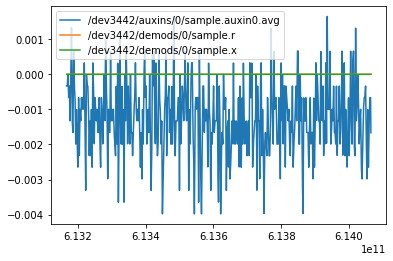

In [88]:
for name, d in data.items():
    plt.plot(d[0].timestamp.values.reshape((-1)), d[0].values.reshape((-1)), label=d[0].name)
plt.legend()
plt.show()

In [68]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(385)measure_program()
    383                                                         channel_name = f"/{device_name}/{input_name}/{signal_name}/{final_level_name}"
    384 							channel_data = xr.DataArray(
--> 385                                                                 data=final_level_data["value"],
    386                                                                 cords={'timestamp': final_level_data['timestamp']},
    387                                                                 dims=['col', 'row'],

ipdb> final_level_data
[{'header': {'systemtime': array([1664382261279112], dtype=uint64), 'createdtimestamp': array([1312194966056], dtype=uint64), 'changedtimestamp': array([1312194966056], dtype=uint64), 'flags': array([825], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '007 18:24:21.2784', 'status': array([0], dtype=uint32), 'groupindex': array([0], dty

In [55]:
while not my_lockin.daq.finished():
    time.sleep(1)
    result = my_lockin.daq.read()
    print(result)
    print(f"Progress {my_lockin.daq.progress()}")

{'forcetrigger': array([0], dtype=int64), 'triggered': array([1], dtype=int64)}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{'dev3442': {'auxins': {'0': {'sample.auxin0.avg': [{'header': {'systemtime': array([1664381184448982], dtype=uint64), 'createdtimestamp': array([1247600892456], dtype=uint64), 'changedtimestamp': array([1247600892456], dtype=uint64), 'flags': array([825], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '002 18:06:24.4482', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'triggernumber': array([0], dtype=uint64), 'gridrows': array([1], dtype=uint32), 'gridcols': array([21763], dtype=uint32), 'gridmode': array([4], dty

In [63]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(376)measure_program()
    374 
    375                 for device_name, device_data in data.items():
--> 376                         for input_name, input_data in device_data.items():
    377                                 for signal_name, signal_data in input_data.items():
    378                                         print(list(signal_data.keys()))

ipdb> device_data
array([0], dtype=int64)
ipdb> data
{'dev3442': {'auxins': {'0': {'sample.auxin0.avg': [{'header': {'systemtime': array([1664381558471132], dtype=uint64), 'createdtimestamp': array([1270042036776], dtype=uint64), 'changedtimestamp': array([1270042036776], dtype=uint64), 'flags': array([825], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '005 18:12:38.4705', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'trigge

In [192]:
my_lockin.daq_read_return

{'awgcontrol': array([0], dtype=int64),
 'bandwidth': array([0.]),
 'bitmask': array([1], dtype=int64),
 'bits': array([1], dtype=int64),
 'buffercount': array([2], dtype=int64),
 'buffersize': array([0.2]),
 'clearhistory': array([0], dtype=int64),
 'count': array([1], dtype=int64),
 'delay': array([-0.001]),
 'device': [''],
 'duration': array([0.]),
 'edge': array([1], dtype=int64),
 'enable': array([1], dtype=int64),
 'endless': array([0], dtype=int64),
 'eventcount': {'mode': array([1], dtype=int64)},
 'fft': {'absolute': array([0], dtype=int64),
  'window': array([1], dtype=int64)},
 'findlevel': array([0], dtype=int64),
 'flags': array([8], dtype=int64),
 'forcetrigger': array([0], dtype=int64),
 'grid': {'cols': array([21763], dtype=int64),
  'direction': array([0], dtype=int64),
  'mode': array([4], dtype=int64),
  'overwrite': array([0], dtype=int64),
  'repetitions': array([1], dtype=int64),
  'rowrepetition': array([0], dtype=int64),
  'rows': array([1], dtype=int64),
  'wa

In [174]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(357)measure_program()
    355 
    356                 data = self.daq.read()
--> 357                 self.daq_read_return.update(data)
    358 
    359                 print(data)

ipdb> data
{'forcetrigger': array([0], dtype=int64), 'triggered': array([1], dtype=int64)}
ipdb> r


In [123]:
my_lockin.clear()

In [145]:
my_lockin.daq.read(flat=True)

{}

In [119]:
my_lockin.daq.read()

{}

In [110]:
my_lockin.force_trigger(None)

In [111]:
dir(my_lockin.daq)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'execute',
 'finish',
 'finished',
 'get',
 'getDouble',
 'getInt',
 'getString',
 'getStringUnicode',
 'help',
 'listNodes',
 'listNodesJSON',
 'progress',
 'read',
 'save',
 'set',
 'subscribe',
 'trigger',
 'unsubscribe']

In [169]:
my_lockin.daq.finished()

False

In [205]:
my_lockin.daq.progress()

array([0.])

In [202]:
my_lockin.daq.set('forcetrigger', 1)

In [114]:
my_lockin.daq.progress()

array([0.])

In [117]:
my_lockin.daq.read()

{'triggered': array([0], dtype=int64)}

In [116]:
my_lockin.daq.finish()

In [193]:
my_lockin.daq.execute()

In [9]:
import time

In [32]:
my_lockin.daq.clear()
my_lockin.daq = my_lockin.api_session.dataAcquisitionModule()

In [33]:
my_lockin.api_session.setDebugLevel(0)

In [37]:
my_lockin.daq.set('device', 'dev3442')
# my_lockin.daq.set('save/directory', 'C:\\Users\\Surrey\\Documents\\Zurich Instruments\\LabOne\\WebServer')
my_lockin.daq.set('type', 1)
my_lockin.daq.set('triggernode', '/dev3442/demods/0/sample.AuxIn0')
my_lockin.daq.set('endless', 0)
my_lockin.daq.set('grid/cols', 1000)
# my_lockin.daq.subscribe('/dev3442/demods/0/sample.R.avg')
my_lockin.daq.subscribe('/dev3442/demods/0/sample.R')
my_lockin.daq.subscribe('/dev3442/demods/0/sample.X')
my_lockin.daq.execute()
my_lockin.daq.set('forcetrigger', 1)
result = 0
while not my_lockin.daq.finished():
    time.sleep(1)
    result = my_lockin.daq.read()
    print(result)
    print(f"Progress {my_lockin.daq.progress()} %\r")

{'forcetrigger': array([0], dtype=int64), 'triggered': array([1], dtype=int64)}
Progress [0.] %
{'dev3442': {'demods': {'0': {'sample.r': [{'header': {'systemtime': array([1664380454830777], dtype=uint64), 'createdtimestamp': array([1204630954536], dtype=uint64), 'changedtimestamp': array([1204630954536], dtype=uint64), 'flags': array([1849], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '100 17:54:14.8306', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'triggernumber': array([0], dtype=uint64), 'gridrows': array([1], dtype=uint32), 'gridcols': array([1000], dtype=uint32), 'gridmode': array([4], dtype=uint32), 'gridoperation': array([1], dtype=uint32), 'griddirection': array([0], dtype=uint32), 'gridrepetitions': array([1], dtype=uint32), 'gridcoldelta': array([0.00059733]), 'gridcoloffset': array([-0.001]), 'gridrowdelta'

In [29]:
while not my_lockin.daq.finished():
    time.sleep(1)
    result = my_lockin.daq.read()
    print(result)
    print(f"Progress {my_lockin.daq.progress()} %\r")

RuntimeError: Timeout during set in dataAcquisitionModule module.

In [35]:
my_lockin.daq.finish()
my_lockin.daq.unsubscribe('*')

In [31]:
my_lockin.daq.clear()

In [78]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(270)arm_program()
    268                                 demod = self._get_demod(c)
    269                                 try:
--> 270                                         self.api_session.set(f'/{self.serial}/{demod}/enable', 1)
    271                                 except RuntimeError  as e:
    272                                         raise

ipdb> self.api_session.setInt('/dev3442/demods/0/enable', 0)
ipdb> r
